In [41]:
import astroprov
from astropy.io.ascii import SExtractor
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import os
from photutils import DAOStarFinder
from photutils import CircularAperture
from photutils import aperture_photometry
#import subproc

from astropy import wcs
from astropy.io import fits
import sys

from astroquery.simbad import Simbad

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.table import Table, vstack
from astropy.table import Column

import collections
import subprocess
from astropy.io import ascii
import time
from astropy.utils.data import clear_download_cache
from astroquery.gaia import Gaia
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [2]:
clear_download_cache()

In [3]:
tables = Gaia.load_tables(only_names=True)
for table in (tables):
    print(table.get_qualified_name())

Retrieving tables...
Parsing tables...
Done.
external.external.apassdr9
external.external.gaiadr2_geometric_distance
external.external.ravedr5_com
external.external.ravedr5_dr5
external.external.ravedr5_gra
external.external.ravedr5_on
public.public.hipparcos
public.public.hipparcos_newreduction
public.public.hubble_sc
public.public.igsl_source
public.public.igsl_source_catalog_ids
public.public.tycho2
public.public.dual
tap_config.tap_config.coord_sys
tap_schema.tap_schema.columns
tap_schema.tap_schema.key_columns
tap_schema.tap_schema.keys
tap_schema.tap_schema.schemas
tap_schema.tap_schema.tables
gaiadr1.gaiadr1.aux_qso_icrf2_match
gaiadr1.gaiadr1.ext_phot_zero_point
gaiadr1.gaiadr1.allwise_best_neighbour
gaiadr1.gaiadr1.allwise_neighbourhood
gaiadr1.gaiadr1.gsc23_best_neighbour
gaiadr1.gaiadr1.gsc23_neighbourhood
gaiadr1.gaiadr1.ppmxl_best_neighbour
gaiadr1.gaiadr1.ppmxl_neighbourhood
gaiadr1.gaiadr1.sdss_dr9_best_neighbour
gaiadr1.gaiadr1.sdss_dr9_neighbourhood
gaiadr1.gaiadr1.tma

In [4]:
def makeDS9RegFile(sexTabList,fileNameBase,tabType):
    for tables in range(len(sexTabList)):
        if tabType == 'dao':
            xcoords = sexTabList[tables]['xcentroid']
            ycoords = sexTabList[tables]['ycentroid']
        elif tabType == 'sex':
            xcoords = sexTabList[tables]['X_IMAGE']
            ycoords = sexTabList[tables]['Y_IMAGE']
        elif tabType == 'iraf':
            xcoords = sexTabList[tables]['X_POS']
            ycoords = sexTabList[tables]['Y_POS']        
        else:
            print('tab type error')
            break
        bigString = 'global color=lightgreen\nimage\n'
        for x in range(len(xcoords)):
            bigString += 'circle({},{},5)\n'.format(xcoords[x],ycoords[x])
        fileName = fileNameBase + '.reg'
        with open(fileName,'w') as f:
            f.write(bigString)
#         print(fileName)
#         print(os.listdir('.'))

In [5]:
def load_wcs_from_file(filename,pixCoord):
    # Load the FITS hdulist using astropy.io.fits
    hdulist = fits.open(filename)

    # Parse the WCS keywords in the primary HDU
    w = wcs.WCS(hdulist[0].header)

    # Print out the "name" of the WCS, as defined in the FITS header
    #print(w.wcs.name)

    # Print out all of the settings that were parsed from the header
    w.wcs.print_contents()

    # Three pixel coordinates of interest.
    # Note we've silently assumed a NAXIS=2 image here.
    # Note also that the pixel coordinates are pairs of [X, Y], 
    # and since WCS built from FITS header automatically has
    # origin set to 1, [0, 0] is actually not inside the image.
    pixcrd = np.array(pixCoord, dtype=np.float_)

    # Convert pixel coordinates to world coordinates
    # The second argument is "origin" -- in this case we're declaring we
    # have 1-based (Fortran-like) coordinates.
    world = w.wcs_pix2world(pixcrd, 1)
    #print(world)
    return(world)

In [6]:
def queryObjectRegion(outputTable,searchRadius=15*u.arcsecond):
    imageCoords = []
    r = searchRadius
    
#     if inCat == 'dao':
#         xlabel = 'xcentroid'
#         ylabel = 'ycentroid'
#         label = 'id'
        
#     if inCat == 'sex':
#         xlabel = 'X_IMAGE'
#         ylabel = 'Y_IMAGE'
#         label = 'NUMBER'
        
    xlabel = 'RA'
    ylabel = 'DEC'
    label = 'NUMBER'
    
    flux = outputTable['FLUX_BEST']   
    ra = outputTable['RA']
    dec = outputTable['DEC']
    tableLength = len(outputTable)
    xcoord = outputTable['X_IMAGE']
    ycoord = outputTable['Y_IMAGE']
    imageCoords = [[x,y] for x,y in zip(xcoord,ycoord)]
    imageNames = outputTable['DIFF_NAME']
    customSimbad = Simbad()
    customSimbad.add_votable_fields('ra(d)','dec(d)','otype')
    customSimbad.remove_votable_fields('coordinates')
            
    result_table = Table([['-'],[0],[0],['-'],[0],[0],[0],['-']],names=('MAIN_ID','RA_d','DEC_d','OTYPE','xcentroid','ycentroid','flux','IMAGE'),dtype=('object','float64','float64','object','float64','float64','float64','object'))


    for x in range(len(imageCoords)):
        try:
            c = SkyCoord(ra[x],dec[x],frame='icrs',unit='deg')
            rt = customSimbad.query_region(c,radius=r)
            rowlist = []
            for y in range(len(rt[0])):
                rowlist.append(rt[0][y])
            rowlist.append(imageCoords[x][0])
            rowlist.append(imageCoords[x][1])
            rowlist.append(flux[x])
            rowlist.append(imageNames[x])
            result_table.add_row(rowlist)

        except:
            #print('searchfailed')
            result_table.add_row(['N/A',ra[x],dec[x],'Object Not Found',[imageCoords[x][0]],[imageCoords[x][1]],flux[x],imageNames[x]])

    
    return result_table

In [7]:
tabTot =  ascii.read('/home/mj1e16/outTablesImproved/sexdiffOutTest.csv')

In [8]:
tabTot = ascii.read('/home/mj1e16/outTablesImproved/firsthalf.csv')

In [61]:
# upload_resource = '/home/mj1e16/outTables15/matchplus3Magdiff.csv'
# j = Gaia.launch_job(query="select * from tap_upload.table_test", upload_resource=upload_resource, \
# upload_table_name="table_test", verbose=True)
# r = j.get_results()
# r.pprint()

In [15]:
def gaiaSearch(table):
    RA = table['RA']
    DEC = table['DEC']
    width = u.Quantity(5., u.arcsecond)
    height = u.Quantity(5., u.arcsecond)
    #coord = [str(RA[0])+','+str(DEC[0])]
    t0 = time.time()
    for x in range(len(RA)):
        coord = SkyCoord(ra=RA[x], dec=DEC[x], unit=(u.degree, u.degree), frame='icrs')
        if x ==0:
            result_table = Gaia.query_object_async(coordinate=coord, width=width, height=height)
        else:
            newtab = Gaia.query_object_async(coordinate=coord, width=width, height=height)
            if len(newtab) != 0:
                result_table.add_row(newtab[0])
    print(time.time() - t0)
    return result_table

In [18]:
def colourMag(table):
    parallax = table['parallax']
    distance = [1./(x/1000.) for x in parallax]
    paraError = table['parallax_error']
    colour = table['bp_rp']
    gmag = table['phot_g_mean_mag']
    extinction = table['a_g_val']


    colourGood = [x for x,y,z in zip(colour,paraError,parallax) if y<0.25*z]
    distanceGood = [x for x,y,z in zip(distance,paraError,parallax) if y<0.25*z]
    gmagGood = [x for x,y,z in zip(gmag,paraError,parallax) if y<0.25*z]
    exctinctionGood = [x for x,y,z in zip(extinction,paraError,parallax) if y<0.25*z]

    absoluteMag = [mag - (5*(np.log10(dist)))  + 5 for mag,dist,ext in zip(gmagGood,distanceGood,exctinctionGood)]
    return {'absMag':absoluteMag,'colour':colourGood}

In [10]:
RA = tabTot['RA']
DEC = tabTot['DEC']
width = u.Quantity(5., u.arcsecond)
height = u.Quantity(5., u.arcsecond)
#coord = [str(RA[0])+','+str(DEC[0])]
t0 = time.time()
for x in range(10000): #len(RA)):
    coord = SkyCoord(ra=RA[x], dec=DEC[x], unit=(u.degree, u.degree), frame='icrs')
    if x ==0:
        result_table = Gaia.query_object_async(coordinate=coord, width=width, height=height)
    else:
        newtab = Gaia.query_object_async(coordinate=coord, width=width, height=height)
        if len(newtab) != 0:
            result_table.add_row(newtab[0])
print(time.time() - t0)

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
4.91826105118


In [12]:
#ascii.write(result_table,'/home/mj1e16/outTablesImproved/gaiaObjects.csv',format='csv',fast_writer=False)
ascii.write(result_table,'/home/mj1e16/outTablesImproved/gaiaTab.csv',format='csv',fast_writer=False)

In [13]:
otherGaiaTab = ascii.read('/home/mj1e16/outTablesImproved/fullMatches.csv')

In [17]:
newGaiaTab = gaiaSearch(otherGaiaTab)

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
16.1608419418


In [22]:
# if using a table previously made
#result_table = ascii.read('/home/mj1e16/outTablesImproved/gaiaTab.csv')

In [23]:
refmagandcolour = colourMag(result_table)

In [24]:
magandcolour =colourMag(newGaiaTab)

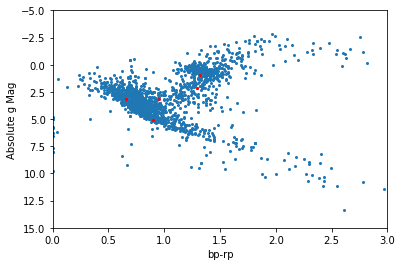

In [25]:
plt.plot(refmagandcolour['colour'],refmagandcolour['absMag'],'o',markersize=2)
plt.plot(magandcolour['colour'],magandcolour['absMag'],'ro',markersize=2)
plt.ylim([-5,15])
plt.xlim([0,3])
plt.gca().invert_yaxis()
plt.ylabel('Absolute g Mag')
plt.xlabel('bp-rp')
plt.show()

In [27]:
gaiaMag = result_table['phot_g_mean_mag']
keplerMag = tabTot['MAG_BEST'][0:10000]

In [37]:
def testfindMatches(tabTot,matchTab,arcsec=2.5*u.arcsec,low=0,high=10000):
    tabMini = tabTot[low:high]
    matches = 'not matched'
    ra1 = matchTab['ra']
    dec1 = matchTab['dec']
    idx = []
    ra2 = tabMini['RA']
    dec2 = tabMini['DEC']    
    c = SkyCoord(ra=ra1, dec=dec1,unit=(u.hourangle,u.deg),frame='fk5')
    catalog = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)
    idx, d2d, d3d = c.match_to_catalog_sky(catalog)
    sep_constraint = d2d < max_sep
#     print(len(matches))
#     print(matches)
    tabMini.remove_rows(idx)
    objectsFound = number1[sep_constraint]
    origdf = bigdf[bigdf['NUMBER'].isin(objectsFound)]
    return tabMini

In [99]:
def findMatchesNoCondition(tab,match,df,bigdf,max_sep = 2.5 * u.arcsec):
    
    number1 = match['index']
    ra1 = match['ra']
    dec1 = match['dec']

    number2 = tab['index'] # difference image
    ra2 = tab['RA']
    dec2 = tab['DEC']    
    
    cat1 = SkyCoord(ra=ra1*u.degree, dec=dec1*u.degree)
    cat2 = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)
    
    idx, d2d, d3d = cat2.match_to_catalog_sky(cat1)
    sep_constraint = d2d < max_sep
    objectsFound = number2[sep_constraint]
    matchdf = df[df['index'].isin(objectsFound)]
    matchTab = Table.from_pandas(matchdf)

    idx, d2d, d3d = cat1.match_to_catalog_sky(cat2)
    sep_constraint = d2d < max_sep
    #istrue = [x for x in sep_constraint if x == True]
    objectsFound = number1[sep_constraint]
    origdf = bigdf[bigdf['index'].isin(objectsFound)]
    origTab = Table.from_pandas(origdf)
    
    return [matchTab,origTab]

In [93]:
indexes = [i for i in range(10000)]
rtindexes = [i for i in range(len(result_table))]
tabMini = tabTot[0:10000]
tabMini['index'] = indexes
result_table['index'] = rtindexes
df = tabMini.to_pandas()
bigdf = result_table.to_pandas()

In [100]:
match = findMatchesNoCondition(tabMini,result_table,df,bigdf)

In [105]:
match[1]

dist,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,index
float64,int64,str28,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,str5,float64,float64,float64,float64,int64,int64,float64,int64,int64,str5,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str13,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,str77,str99,int64
0.0004856895386947052,1635721458409799680,Gaia DR2 2101397003944879744,2101397003944879744,1460115014,2015.5,290.1541864197112,0.5432112779766552,40.9350567951846,0.7683634845762366,-1.3875383085515758,0.6925544086393817,-2.003508,-1.6469723906519274,1.1554458124932419,0.02832046423850106,1.7692631528420302,0.08079609,0.26672313,0.08902849,-0.30213055,0.26576456,-0.3175182,-0.115155965,-0.06868647,0.057202842,0.013251644,167,0,167,0,1.933488,198.58994,1.4973966196441795,0.7626853853394648,31,False,0.037213326,1.7492072531715066,0.1656579173208149,0.21154217,20,14,1.5636353,0,22,False,185,115.98480231678155,0.9944445855181093,116.632744,20.527363,14,96.61784003532408,15.769214245003758,6.1269913,20.388744,15,109.9780189881386,9.456519384464732,11.629863,19.658655,1.7812321,0,0.7300892,-0.13861847,0.86870766,0.0,0.0,0,0.0,0.0,0.0,NOT_AVAILABLE,72.8462236301454,12.321236533507404,303.7161711816616,62.03556137263401,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,http://geadata.esac.esa.int/data-server/datalink/links?ID=2101397003944879744,--,0
0.0004220522502123424,1635721458409799680,Gaia DR2 2101399306052024832,2101399306052024832,760687150,2015.5,290.3191674090691,0.01146370356861856,41.038643828467215,0.013157286534784192,2.6444742383694697,0.014254419301190787,185.5196,-5.097038692635611,0.02495669795514842,-0.9655807078618102,0.02803366587614792,0.030564,0.00073369377,-0.053977344,-0.042234153,0.19177416,-0.077061795,-0.1397227,-0.18708868,-0.16435198,0.062010564,235,0,233,2,-4.561351,143.31865,0.0,0.0,31,True,91.91692,1.5463240794613022,0.0035608379413206246,0.09213

In [104]:
match[0]

NUMBER,FLUX_BEST,FLUXERR_BEST,MAG_BEST,X_IMAGE,Y_IMAGE,ELLIPTICITY,RA,DEC,IMAGE_NAME,MEDIAN_NAME,DIFF_NAME,index
int64,float64,float64,float64,float64,float64,float64,float64,float64,str34,str18,str32,int64
7,11456.36,280.9146,14.8524,574.5563,1008.829,0.434,290.154244155043,40.93553403531398,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,6
10,2277.93,34.05597,16.6061,429.0159,992.2977,0.058,290.3189672067992,41.03903357582664,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,9
16,3054.787,57.26656,16.2875,431.1161,902.2485,0.255,290.24398542974404,41.12090268582241,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,15
20,3052.171,35.77414,16.2885,1067.9397,878.5374,0.074,289.44881212003037,40.75399198948763,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,19
25,643.2305,26.07466,17.9791,906.3129,742.7368,0.252,289.5346598957401,40.97787958211275,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,24
37,2050.519,31.83027,16.7203,757.8644,625.5156,0.049,289.62014431369175,41.176573052631966,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,36
51,1316.578,21.60069,17.2014,846.3585,411.3842,0.136,289.3370440227031,41.31871402777068,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,50
59,3098.985,36.51183,16.272,521.098,316.912,0.171,289.6580544878012,41.605185276102596,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,58
61,10156.0,43.35539,14.9832,761.9088,241.4618,0.003,289.3006230731252,41.52648056165964,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,60


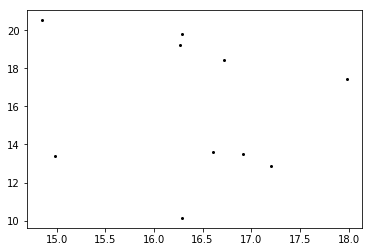

In [112]:
keplerMag = match[0]['MAG_BEST']
gaiaMag = match[1]['phot_g_mean_mag']
plt.plot(keplerMag[0:10],gaiaMag[0:10],'ko',markersize=2)
plt.show()

In [110]:
match[0][0:10]

NUMBER,FLUX_BEST,FLUXERR_BEST,MAG_BEST,X_IMAGE,Y_IMAGE,ELLIPTICITY,RA,DEC,IMAGE_NAME,MEDIAN_NAME,DIFF_NAME,index
int64,float64,float64,float64,float64,float64,float64,float64,float64,str34,str18,str32,int64
7,11456.36,280.9146,14.8524,574.5563,1008.829,0.434,290.154244155043,40.93553403531398,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,6
10,2277.93,34.05597,16.6061,429.0159,992.2977,0.058,290.3189672067992,41.03903357582664,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,9
16,3054.787,57.26656,16.2875,431.1161,902.2485,0.255,290.24398542974404,41.12090268582241,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,15
20,3052.171,35.77414,16.2885,1067.9397,878.5374,0.074,289.44881212003037,40.75399198948763,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,19
25,643.2305,26.07466,17.9791,906.3129,742.7368,0.252,289.5346598957401,40.97787958211275,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,24
37,2050.519,31.83027,16.7203,757.8644,625.5156,0.049,289.62014431369175,41.176573052631966,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,36
51,1316.578,21.60069,17.2014,846.3585,411.3842,0.136,289.3370440227031,41.31871402777068,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,50
59,3098.985,36.51183,16.272,521.098,316.912,0.171,289.6580544878012,41.605185276102596,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,58
61,10156.0,43.35539,14.9832,761.9088,241.4618,0.003,289.3006230731252,41.52648056165964,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,60


In [111]:
match[1][0:10]

dist,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,index
float64,int64,str28,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,str5,float64,float64,float64,float64,int64,int64,float64,int64,int64,str5,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str13,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,str77,str99,int64
0.0004856895386947052,1635721458409799680,Gaia DR2 2101397003944879744,2101397003944879744,1460115014,2015.5,290.1541864197112,0.5432112779766552,40.9350567951846,0.7683634845762366,-1.3875383085515758,0.6925544086393817,-2.003508,-1.6469723906519274,1.1554458124932419,0.02832046423850106,1.7692631528420302,0.08079609,0.26672313,0.08902849,-0.30213055,0.26576456,-0.3175182,-0.115155965,-0.06868647,0.057202842,0.013251644,167,0,167,0,1.933488,198.58994,1.4973966196441795,0.7626853853394648,31,False,0.037213326,1.7492072531715066,0.1656579173208149,0.21154217,20,14,1.5636353,0,22,False,185,115.98480231678155,0.9944445855181093,116.632744,20.527363,14,96.61784003532408,15.769214245003758,6.1269913,20.388744,15,109.9780189881386,9.456519384464732,11.629863,19.658655,1.7812321,0,0.7300892,-0.13861847,0.86870766,0.0,0.0,0,0.0,0.0,0.0,NOT_AVAILABLE,72.8462236301454,12.321236533507404,303.7161711816616,62.03556137263401,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,http://geadata.esac.esa.int/data-server/datalink/links?ID=2101397003944879744,--,0
0.0004220522502123424,1635721458409799680,Gaia DR2 2101399306052024832,2101399306052024832,760687150,2015.5,290.3191674090691,0.01146370356861856,41.038643828467215,0.013157286534784192,2.6444742383694697,0.014254419301190787,185.5196,-5.097038692635611,0.02495669795514842,-0.9655807078618102,0.02803366587614792,0.030564,0.00073369377,-0.053977344,-0.042234153,0.19177416,-0.077061795,-0.1397227,-0.18708868,-0.16435198,0.062010564,235,0,233,2,-4.561351,143.31865,0.0,0.0,31,True,91.91692,1.5463240794613022,0.0035608379413206246,0.09213